# **Early-Fusion**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Valentina Barbera, Vittorio Haardt, Luca Porcelli, Luca Sinanaj

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Progetto/Data.zip" -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/Data/TCGA-CS-6188/flair_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_79.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_82.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_83.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_85.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_89.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_92.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_94.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_57.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_58.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_63.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_65.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_67.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_68.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_73.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_75.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_79.nii.gz  
  infla

In [ ]:
#!unzip "/content/drive/MyDrive/Medical Imaging & Big Data/Progetto/Data.zip" -d Data

# Installing packages and loading libraries

In [3]:
from torch.utils.data import DataLoader
import torch
import sys
#sys.path.append('/content/drive/MyDrive/Medical Imaging & Big Data/Progetto')
sys.path.append('/content/drive/MyDrive/Progetto')
from dataset import BraTS
import numpy as np
import random
from glob import glob
import torchvision.transforms as transforms
from unet_model_EF import UNet
from torch.nn import functional as F
from tqdm import tqdm

import os
import logging
from time import time
from os.path import dirname as up
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt

# Seed

In [5]:
def seed_all(seed):
    # Pytorch Reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    # DataLoader Workers Reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Data

### Reproducibility

In [6]:
seed_all(0)
g=torch.Generator()
g.manual_seed(0)

### Construct Data loader

In [7]:
dataset_train = BraTS("/content/Data/Data", 'train')
dataset_val = BraTS("/content/Data/Data", 'val')
dataset_test = BraTS("/content/Data/Data", 'test')

Loading test data: 100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


In [ ]:
train_loader = DataLoader(dataset_train,
                          batch_size = 5,
                          shuffle = True,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g,
                          drop_last=True)

In [ ]:
val_loader = DataLoader(dataset_val,
                          batch_size = 5,
                          shuffle = False,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g)

In [ ]:
test_loader = DataLoader(dataset_test,
                          batch_size = 1,
                          shuffle = False)

# GPU presence check

In [ ]:
# Use gpu or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 4 are the number of input bands and 4 are the classes including the background
model = UNet(4, 4)

model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Training

### Cross Entropy Loss & adam optimizer

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Learning Rate scheduler

In [ ]:
reduce_lr_on_plateau=0
if reduce_lr_on_plateau==1:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
else:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, '[45,65]', gamma=0.1)

### Start training

In [ ]:
epochs = 100
eval_every = 1

In [ ]:
# Train
model.train()

train_losses = []  # List to record training losses
val_losses = []    # List to record validation losses

for epoch in tqdm(range(1, epochs + 1)):
    training_loss = []
    training_batches = 0
    for it, (image, target) in enumerate(train_loader):

        image = image.to(device)
        target = target.to(device).long()

        optimizer.zero_grad()  # Resets gradients
        logits2 = F.upsample(input=model(image), size=image.size()[2:4], mode='bilinear')  # Runs the model
        loss = criterion(logits2, target)  # Computes the loss function

        loss.backward()  # Computes gradients
        training_batches += target.shape[0]  # Updates the count of training batches
        training_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
        torch.nn.utils.clip_grad_norm_(model.parameters(), float('inf'))  # Applies gradient clipping
        optimizer.step()  # Updates model weights using the optimizer

    print("Training loss was: " + str(sum(training_loss) / training_batches))  # Prints the average training loss per epoch
    train_losses.append(sum(training_loss) / training_batches)  # Records the average training loss per epoch in the list

    # Saves the model
    model_dir = os.path.join(os.path.join(up(os.path.abspath("/content/drive/MyDrive/Progetto/results")), 'trained_models_EF'), str(epoch))
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pth'))

    if epoch % eval_every == 0 or epoch == 1:  # Evaluates the model on validation data
        model.eval()
        val_loss = []
        val_batches = 0
        y_true_val = []
        y_predicted_val = []
        seed_all(0)
        with torch.no_grad():
            for (image, target) in val_loader:

                image = image.to(device)
                target = target.to(device).long()

                logits = model(image)  # Runs the model
                logits = F.upsample(input=logits, size=(target.shape[-2], target.shape[-1]), mode='bilinear')  # Bilinear upsampling of logits
                loss = criterion(logits, target)  # Computes the loss function

                logits = torch.movedim(logits, (0, 1, 2, 3), (0, 3, 1, 2))  # Moves dimensions to compute probabilities
                logits = logits.reshape((-1, 4))  # Reshapes logits
                target = target.reshape(-1)  # Reshapes targets
                mask = target != 0  # Creates a mask for non-empty targets

                logits = logits[mask]
                target = target[mask]

                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Computes probabilities
                target = target.cpu().numpy()
                val_batches += target.shape[0]  # Updates the count of validation batches
                val_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
                y_predicted_val += probs.argmax(1).tolist()  # Adds predictions to the list
                y_true_val += target.tolist()  # Adds true targets to the list

            y_predicted_val = np.asarray(y_predicted_val)
            y_true_val = np.asarray(y_true_val)
            subset_acc = accuracy_score(y_true_val, y_predicted_val)  # Computes accuracy
            print("Acc" + str(subset_acc))  # Prints accuracy

        val_losses.append(sum(val_loss) / val_batches)  # Records the average validation loss per epoch in the list
        scheduler.step()  # Updates the scheduler
        model.train()  # Restores the model to training mode

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.15635931580155


  1%|          | 1/100 [01:11<1:57:36, 71.27s/it]

Acc0.0016512657168991837


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9993527935169362


  2%|▏         | 2/100 [02:20<1:54:30, 70.11s/it]

Acc0.0058565614998707235


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9072409774638989


  3%|▎         | 3/100 [03:30<1:52:55, 69.85s/it]

Acc0.0613075851759793


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8531297828533031


  4%|▍         | 4/100 [04:39<1:51:35, 69.75s/it]

Acc0.20901113083456274


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8206534592310587


  5%|▌         | 5/100 [05:48<1:50:02, 69.50s/it]

Acc0.15400334164035867


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8018068710962931


  6%|▌         | 6/100 [06:58<1:48:49, 69.46s/it]

Acc0.35737952821600294


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7913242401900115


  7%|▋         | 7/100 [08:07<1:47:42, 69.49s/it]

Acc0.3502540993757781


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7842684742256447


  8%|▊         | 8/100 [09:17<1:46:35, 69.52s/it]

Acc0.2629401655176609


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7799963929918077


  9%|▉         | 9/100 [10:26<1:45:18, 69.44s/it]

Acc0.2240517715256609


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7764485567587394


 10%|█         | 10/100 [11:35<1:44:05, 69.40s/it]

Acc0.4672343254688182


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7739062595367432


 11%|█         | 11/100 [12:45<1:43:14, 69.60s/it]

Acc0.3162021757598538


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7723185848306726


 12%|█▏        | 12/100 [13:55<1:41:58, 69.53s/it]

Acc0.40775182345362226


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7706550027706005


 13%|█▎        | 13/100 [15:05<1:40:55, 69.60s/it]

Acc0.22949008480118543


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7689226726249412


 14%|█▍        | 14/100 [16:14<1:39:47, 69.63s/it]

Acc0.40692727695419695


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7686365581441809


 15%|█▌        | 15/100 [17:24<1:38:40, 69.65s/it]

Acc0.27221984430302465


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7668611842614633


 16%|█▌        | 16/100 [18:34<1:37:30, 69.64s/it]

Acc0.39381926896728536


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7659659627631858


 17%|█▋        | 17/100 [19:43<1:36:27, 69.73s/it]

Acc0.46767864630974704


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7655356991732563


 18%|█▊        | 18/100 [20:53<1:35:17, 69.73s/it]

Acc0.4105350752738168


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7648934600971363


 19%|█▉        | 19/100 [22:03<1:33:57, 69.60s/it]

Acc0.45184930896702463


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7634474289858783


 20%|██        | 20/100 [23:12<1:32:41, 69.52s/it]

Acc0.521851025414283


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7627078063399704


 21%|██        | 21/100 [24:21<1:31:23, 69.42s/it]

Acc0.3799258234058224


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7622879724149351


 22%|██▏       | 22/100 [25:30<1:30:12, 69.39s/it]

Acc0.507468718291896


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7617707248970315


 23%|██▎       | 23/100 [26:40<1:29:14, 69.54s/it]

Acc0.582854430063465


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7608184153945358


 24%|██▍       | 24/100 [27:50<1:28:00, 69.48s/it]

Acc0.4182634333725147


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7603513037716901


 25%|██▌       | 25/100 [28:59<1:26:52, 69.50s/it]

Acc0.5429872265905926


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7600843192912914


 26%|██▌       | 26/100 [30:09<1:25:51, 69.62s/it]

Acc0.5253469287544025


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7592946723655418


 27%|██▋       | 27/100 [31:19<1:24:47, 69.69s/it]

Acc0.5063823592676202


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7590086532522131


 28%|██▊       | 28/100 [32:29<1:23:37, 69.68s/it]

Acc0.550674303046368


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7580009319164135


 29%|██▉       | 29/100 [33:39<1:22:33, 69.77s/it]

Acc0.5088614305610175


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7581694361015603


 30%|███       | 30/100 [34:48<1:21:19, 69.71s/it]

Acc0.5627241973436349


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7572114949756198


 31%|███       | 31/100 [35:58<1:20:11, 69.73s/it]

Acc0.5259639806801911


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7567972642404062


 32%|███▏      | 32/100 [37:08<1:19:14, 69.92s/it]

Acc0.5236174451877554


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7575822574120981


 33%|███▎      | 33/100 [38:18<1:17:57, 69.82s/it]

Acc0.487705674922271


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7569170565075345


 34%|███▍      | 34/100 [39:28<1:16:52, 69.89s/it]

Acc0.5234523186160656


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.756327128763552


 35%|███▌      | 35/100 [40:38<1:15:43, 69.90s/it]

Acc0.5472251131442923


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7563324497364186


 36%|███▌      | 36/100 [41:48<1:14:34, 69.92s/it]

Acc0.5474054487423221


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7557016296739931


 37%|███▋      | 37/100 [42:57<1:13:15, 69.77s/it]

Acc0.5748686048760139


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7556552977032132


 38%|███▊      | 38/100 [44:07<1:12:05, 69.76s/it]

Acc0.655663298229452


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7551013872358534


 39%|███▉      | 39/100 [45:17<1:11:01, 69.87s/it]

Acc0.49560676410582877


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7549778659255416


 40%|████      | 40/100 [46:27<1:09:52, 69.88s/it]

Acc0.651928395903992


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7545372917034008


 41%|████      | 41/100 [47:37<1:08:41, 69.86s/it]

Acc0.5779353964015443


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7545605481112445


 42%|████▏     | 42/100 [48:46<1:07:26, 69.76s/it]

Acc0.6458958442421885


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7539318656921387


 43%|████▎     | 43/100 [49:56<1:06:11, 69.68s/it]

Acc0.6360045453261576


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7542089785469903


 44%|████▍     | 44/100 [51:05<1:04:56, 69.57s/it]

Acc0.6558925199835742


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7542081905294348


 45%|████▌     | 45/100 [52:15<1:03:51, 69.66s/it]

Acc0.6325010374728682


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7534527593188816


 46%|████▌     | 46/100 [53:24<1:02:32, 69.48s/it]

Acc0.6515568611176896


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.753294964366489


 47%|████▋     | 47/100 [54:33<1:01:21, 69.46s/it]

Acc0.6492440027550065


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7534537806334319


 48%|████▊     | 48/100 [55:43<1:00:16, 69.56s/it]

Acc0.6336721325010375


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7537902063793607


 49%|████▉     | 49/100 [56:53<59:09, 69.60s/it]  

Acc0.6518534371313169


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7535456510826394


 50%|█████     | 50/100 [58:02<57:53, 69.48s/it]

Acc0.6366433244324318


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7528903117003264


 51%|█████     | 51/100 [59:12<56:44, 69.48s/it]

Acc0.5581908211353321


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7527550517188178


 52%|█████▏    | 52/100 [1:00:21<55:32, 69.42s/it]

Acc0.6644736699163286


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7525419229931302


 53%|█████▎    | 53/100 [1:01:30<54:21, 69.39s/it]

Acc0.5830760473044173


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7523308397222448


 54%|█████▍    | 54/100 [1:02:41<53:25, 69.69s/it]

Acc0.6346368193145944


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7518967663800274


 55%|█████▌    | 55/100 [1:03:50<52:13, 69.63s/it]

Acc0.6819879501057027


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7522961434611568


 56%|█████▌    | 56/100 [1:05:00<51:03, 69.62s/it]

Acc0.6811003947828694


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7519564768120095


 57%|█████▋    | 57/100 [1:06:10<49:58, 69.72s/it]

Acc0.6720933921125989


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7520772988707931


 58%|█████▊    | 58/100 [1:07:19<48:47, 69.71s/it]

Acc0.6283674413854988


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7521145297862866


 59%|█████▉    | 59/100 [1:08:29<47:35, 69.65s/it]

Acc0.5910640452099172


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7525966676076253


 60%|██████    | 60/100 [1:09:38<46:24, 69.61s/it]

Acc0.6425846219361959


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7518077260476571


 61%|██████    | 61/100 [1:10:48<45:10, 69.51s/it]

Acc0.6725931172637658


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7513572959546689


 62%|██████▏   | 62/100 [1:11:57<43:59, 69.45s/it]

Acc0.6696447388718814


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7517143173570986


 63%|██████▎   | 63/100 [1:13:06<42:48, 69.42s/it]

Acc0.702512531151345


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7515858111558137


 64%|██████▍   | 64/100 [1:14:16<41:39, 69.42s/it]

Acc0.5900537313173407


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7516849478968868


 65%|██████▌   | 65/100 [1:15:25<40:27, 69.36s/it]

Acc0.6743617097552868


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7516161152168557


 66%|██████▌   | 66/100 [1:16:34<39:18, 69.37s/it]

Acc0.6912611107369208


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7511229878884774


 67%|██████▋   | 67/100 [1:17:44<38:08, 69.35s/it]

Acc0.6520446363195894


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.751072762630604


 68%|██████▊   | 68/100 [1:18:54<37:05, 69.54s/it]

Acc0.6688994965812282


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7510751397521408


 69%|██████▉   | 69/100 [1:20:03<35:55, 69.53s/it]

Acc0.5601864626629267


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7513098340564304


 70%|███████   | 70/100 [1:21:13<34:48, 69.60s/it]

Acc0.7069296669440503


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.75171709979022


 71%|███████   | 71/100 [1:22:22<33:36, 69.53s/it]

Acc0.6989123373448951


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7508077183476201


 72%|███████▏  | 72/100 [1:23:32<32:28, 69.58s/it]

Acc0.69681240535097


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505883511790523


 73%|███████▎  | 73/100 [1:24:42<31:20, 69.66s/it]

Acc0.6819043004608335


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505700153774685


 74%|███████▍  | 74/100 [1:25:51<30:08, 69.54s/it]

Acc0.7070937071567159


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750386528438992


 75%|███████▌  | 75/100 [1:27:00<28:55, 69.43s/it]

Acc0.7088405724677515


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7504128309532448


 76%|███████▌  | 76/100 [1:28:10<27:48, 69.52s/it]

Acc0.6912828379174063


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505639512450607


 77%|███████▋  | 77/100 [1:29:19<26:37, 69.47s/it]

Acc0.6623378880746025


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7504804047831782


 78%|███████▊  | 78/100 [1:30:28<25:26, 69.37s/it]

Acc0.7028742887064289


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7501694728710033


 79%|███████▉  | 79/100 [1:31:38<24:18, 69.47s/it]

Acc0.6576752351424108


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7503318843135127


 80%|████████  | 80/100 [1:32:47<23:07, 69.40s/it]

Acc0.6728255980949608


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7506507643946895


 81%|████████  | 81/100 [1:33:57<21:59, 69.43s/it]

Acc0.6661520946088347


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7503346489093922


 82%|████████▏ | 82/100 [1:35:07<20:51, 69.51s/it]

Acc0.613957975287505


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.749978947462859


 83%|████████▎ | 83/100 [1:36:16<19:39, 69.37s/it]

Acc0.6765061824692071


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7500911555466828


 84%|████████▍ | 84/100 [1:37:25<18:29, 69.34s/it]

Acc0.7034022591922269


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7503988652759128


 85%|████████▌ | 85/100 [1:38:35<17:21, 69.45s/it]

Acc0.6857087297638472


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.75016768667433


 86%|████████▌ | 86/100 [1:39:45<16:14, 69.62s/it]

Acc0.6610907479147339


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7498791684044732


 87%|████████▋ | 87/100 [1:40:54<15:02, 69.42s/it]

Acc0.6840053188137829


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7497507971304435


 88%|████████▊ | 88/100 [1:42:03<13:53, 69.48s/it]

Acc0.6811547127340832


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7498393097630254


 89%|████████▉ | 89/100 [1:43:12<12:43, 69.42s/it]

Acc0.6534992710530947


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7501339197158814


 90%|█████████ | 90/100 [1:44:22<11:34, 69.44s/it]

Acc0.6560413511699


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7511266386950457


 91%|█████████ | 91/100 [1:45:31<10:25, 69.47s/it]

Acc0.673645799158289


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7496833451588949


 92%|█████████▏| 92/100 [1:46:41<09:16, 69.53s/it]

Acc0.681536024751604


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7494772088086163


 93%|█████████▎| 93/100 [1:47:51<08:07, 69.60s/it]

Acc0.6429800566210323


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.749369112473947


 94%|█████████▍| 94/100 [1:49:01<06:58, 69.74s/it]

Acc0.6773090017881469


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7500892948221277


 95%|█████████▌| 95/100 [1:50:11<05:48, 69.68s/it]

Acc0.6809417863653252


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7496752090807314


 96%|█████████▌| 96/100 [1:51:20<04:38, 69.51s/it]

Acc0.7121137722078944


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.749426558635853


 97%|█████████▋| 97/100 [1:52:29<03:28, 69.57s/it]

Acc0.6948830317238562


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7493467164922644


 98%|█████████▊| 98/100 [1:53:39<02:19, 69.51s/it]

Acc0.6617154043536925


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7492926184336345


 99%|█████████▉| 99/100 [1:54:48<01:09, 69.51s/it]

Acc0.6552526545182759


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7498320549505728


100%|██████████| 100/100 [1:55:58<00:00, 69.59s/it]

Acc0.6795512468142522


### Loss visualization for epochs

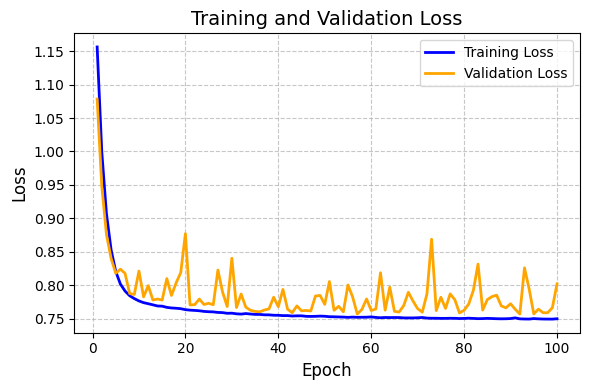

In [ ]:
plt.figure(figsize=(6, 4))

epochs = len(train_losses)

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

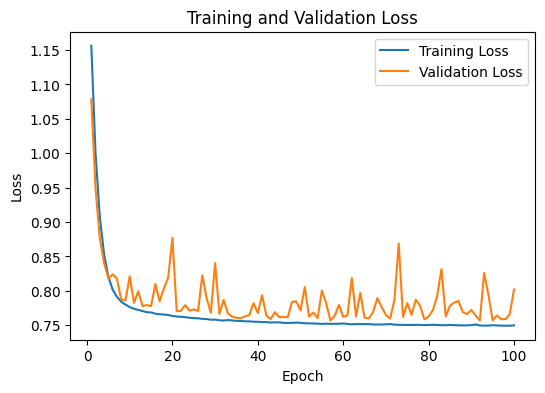

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

### Loading model

In [ ]:
models_list = []
models_files = glob(os.path.join(os.path.join("/content/drive/MyDrive/Progetto/trained_models_EF/", '100'),'*.pth'))

for model_file in models_files:

    model = UNet(4, 4)

    model.to(device)

    # Load model from specific epoch to continue the training or start the evaluation
    checkpoint = torch.load(model_file, map_location = device)
    checkpoint = {k.replace('decoder','decode_head'):v for k,v in checkpoint.items() if ('proj1' not in k) and ('proj2' not in k)}

    # Modify keys in the loaded checkpoint dictionary to match the model's expected keys
    checkpoint = {k.replace('decode_head', 'decoder'): v for k, v in checkpoint.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(checkpoint)

    del checkpoint  # dereference
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.eval()

    models_list.append(model)

### Evaluation

In [ ]:
a=[]
b=[]
inputs_list = []
y_true = []
y_predicted = []

In [ ]:
def dice_coefficient_multiclass(y_true, y_pred, num_classes):
    dice_scores = []
    for class_label in range(1, num_classes):
        y_true_class = [1 if x == class_label else 0 for x in y_true]
        y_pred_class = [1 if x == class_label else 0 for x in y_pred]
        intersection = sum(y_true_class[i] * y_pred_class[i] for i in range(len(y_true)))
        union = sum(y_true_class) + sum(y_pred_class)
        dice = (2. * intersection) / (union)
        dice_scores.append(dice)
    return dice_scores

In [ ]:
with torch.no_grad():
    for (image, target) in tqdm(test_loader, desc="testing"):
        image = image.to(device)
        target = target.to(device)
        seed_all(0)

        all_predictions = []
        logits = model(image)  # Forward pass to get logits from the model

        im_input = (image[0].detach().cpu().numpy())  # Convert the first image to a numpy array and detach from the computation graph
        inputs_list.append(im_input)  # Append the input image to a list (for visualization)

        # Accuracy metrics only on annotated pixels
        probs = torch.nn.functional.softmax(logits, dim=1)  # Compute softmax probabilities from logits
        predictions = probs.argmax(1)  # Get the class predictions by selecting the index of the maximum probability
        predictions = predictions.reshape(-1)  # Reshape predictions to a 1D array

        a.append(target.cpu().numpy())
        b.append(predictions.cpu().numpy())

        target = target.reshape(-1)  # Reshape true targets to a 1D array
        mask = target != 0  # Create a mask for non-zero targets
        predictions = predictions[mask].cpu().numpy()  # Apply the mask to predictions and convert to numpy array
        target = target[mask]  # Apply the mask to true targets
        target = target.cpu().numpy()  # Convert true targets to numpy array
        y_predicted += predictions.tolist()  # Add predictions to the list 'y_predicted'
        y_true += target.tolist()  # Add true targets to the list 'y_true'

    # Calculate and print scores
    subset_acc = accuracy_score(y_true, y_predicted)  # Compute subset accuracy
    iou_acc = jaccard_score(y_true, y_predicted, average='macro')  # Compute IoU
    dice_coeff = dice_coefficient_multiclass(y_true, y_predicted, 4)  # Compute Dice coefficient
    print("accuracy_score: " + str(subset_acc))
    print("IoU: " + str(iou_acc))
    print("Dice coefficient: class1: " + str(dice_coeff[0]) + " class2: " + str(dice_coeff[1]) + " class3: " + str(dice_coeff[2]))

testing: 100%|██████████| 812/812 [00:14<00:00, 58.00it/s]


accuracy_score: 0.6872755872967965
IoU: 0.43997872182269704
Dice coefficient: class1: 0.7040319286867518 class2: 0.7742508570161625 class3: 0.7381797096545075


### Visual evaluation

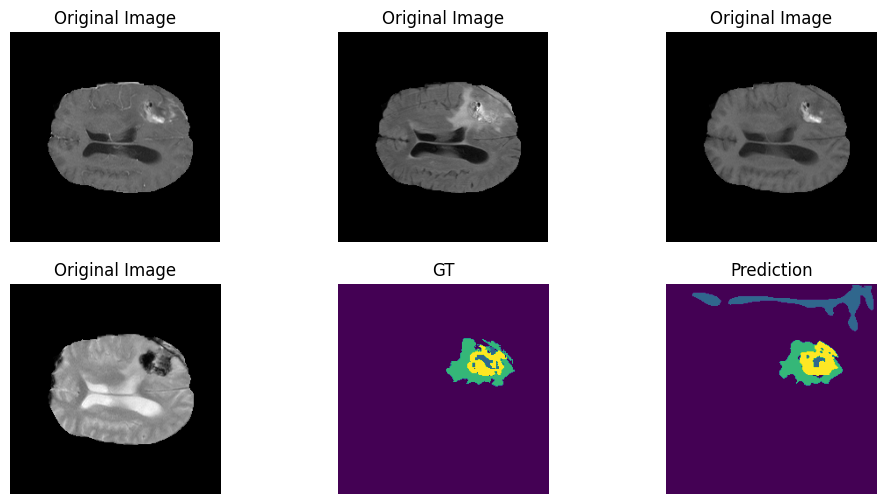

In [ ]:
n = 60

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(inputs_list[n][0,:,:], cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
axes[0, 1].imshow(inputs_list[n][1,:,:], cmap='gray')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')
axes[0, 2].imshow(inputs_list[n][2,:,:], cmap='gray')
axes[0, 2].set_title('Original Image')
axes[0, 2].axis('off')
axes[1, 0].imshow(inputs_list[n][3,:,:], cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')


axes[1, 1].imshow(np.resize(a[n], (240, 240)))
axes[1, 1].set_title('GT')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.resize(b[n], (240, 240)))
axes[1, 2].set_title('Prediction')
axes[1, 2].axis('off')
plt.show()